In [8]:
%load_ext nb_black
import msprime as msp
from IPython.display import SVG, display, set_matplotlib_formats
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

%matplotlib inline
set_matplotlib_formats("svg")
plt.style.use("seaborn")
import numpy as np


def plot_pop(N, G, r, seed=1, follow="both", ax=None):
    np.random.seed(seed)
    ax.scatter(*np.mgrid[: 2 * N, :G], alpha=0.2)
    ancestral = np.array([True] * 2 * N)
    for i in range(G):
        new_ancestral = np.array([False] * 2 * N)
        recombinants = np.random.rand(2 * N) < r
        parents = np.sort(np.random.choice(2 * N, 2 * N + recombinants.sum()))
        p = 0
        for j, (a, rr) in enumerate(zip(ancestral, recombinants)):
            color = "red" if not rr else "blue"
            for k in range(1 + rr):
                pp = parents[p]
                x = [j, pp]
                p += 1
                y = [G - i, G - (i + 1)]
                if rr and (
                    (k == 0 and follow == "right") or (k == 1 and follow == "left")
                ):
                    continue
                if a:
                    ax.plot(x, y, color=color)
                new_ancestral[pp] |= ancestral[j]
        ancestral = new_ancestral
    ax.set_ylim(G, 0)

<IPython.core.display.Javascript object>

# Lecture 5
## The coalescent with recombination
In today's lecture we'll introduce recombination to our coalescent model.

Up to now we have considered the ancestry of a single gene:

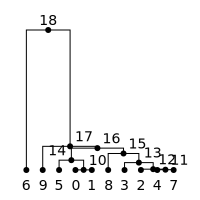

<IPython.core.display.Javascript object>

In [9]:
SVG(msp.simulate(sample_size=10).first().draw("svg"))

In reality we have many genes---around 25,000 in humans. How do we model this?

## Chromosomes, sequences, and genes
We possess a total of 46 chromosomes: 44 autosomes (22 each from our mother and father), plus two sex chromosomes:

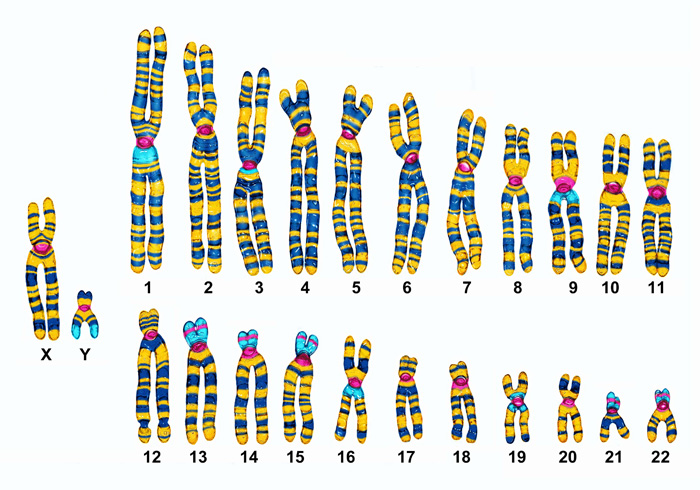

Each chromosome consists of a certain length of DNA sequence. They are ordered from largest to smallest. The largest chromosome, 1, contains roughly 249 million base pairs. The smallest, 22, contains about 50 million bp.

 A gene is a portion of DNA that encodes a protein. Each chromosome contains many genes. Chr1 contains 1.961 genes; chr22 contains 417. You can browse the chromosomes, their genes, and even their raw sequences by going to the [NCBI Genome Browser](https://www.ncbi.nlm.nih.gov/projects/sviewer/?id=NC_000001.11&tracks=[key:gene_model_track,name:Genes\,%20Ensembl%20release%20101,display_name:Genes\,%20Ensembl%20release%20101,id:T2225242,subkey:gene_model,dbname:SADB,category:Genes,subcategory:Other%20Sources,annots:NA000270210.1,Options:MergeAll,CDSProductFeats:false,NtRuler:true,AaRuler:true,HighlightMode:2,ShowLabel:true,shown:true,order:0][key:sequence_track,name:Sequence,display_name:Sequence,id:T15993,subkey:sequence,dbname:GenBank,category:Sequence,subcategory:Assembly,annots:NA,ShowLabel:false,ColorGaps:false,shown:true,order:1]&assm_context=GCF_000001405.38&app_context=genome&v=47674853:158921371&c=null&select=null&slim=0).

## Meiotic recombination
During the process of meiosis (gamete formation), homologous chromosomes will physically cross over and "swap" portions of genetic information. (If you need to review meiosis, I suggest watching this [short video](https://www.youtube.com/watch?v=BlnUNmfGn7I).)

![morgan's original illustration](https://upload.wikimedia.org/wikipedia/commons/0/0e/Morgan_crossover_1.jpg)

This model illustrates Morgan's [bead theory](https://en.wikipedia.org/wiki/Bead_theory) of chromosomal organization. This theory was later disproved, but it's conceptually useful if you are new to this subject.

In terms of our model, recombination has the effect that genes that are far apart on a chromosome may have different genealogies.

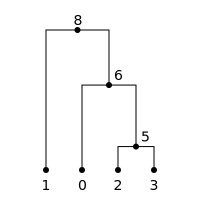

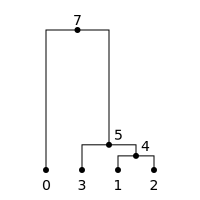

<IPython.core.display.Javascript object>

In [10]:
sim = msp.simulate(sample_size=4, length=1e6, recombination_rate=2e-6, random_seed=1)
display(SVG(sim.first().draw()))  # print first simulated tree
display(SVG(sim.last().draw()))  # print last simulated tree

## Two-locus model
To build intuition for this process, we will consider first a Wright-Fisher model with only two genes. Our "genome" looks like two balls connected by a piece of string:

With probability $1-r$, both genes are inherited from the same parent in the preceding generation:
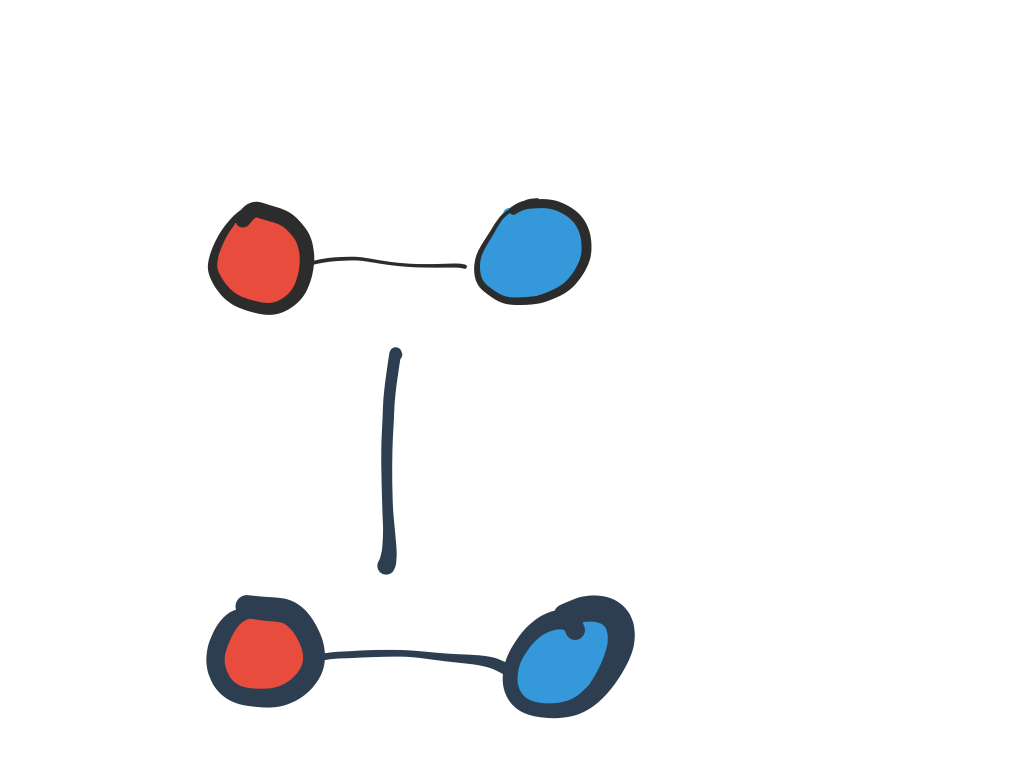

But with probability $r$, a recombination happens, and the offspring inherits the genes from two different parents in the preceding generation.

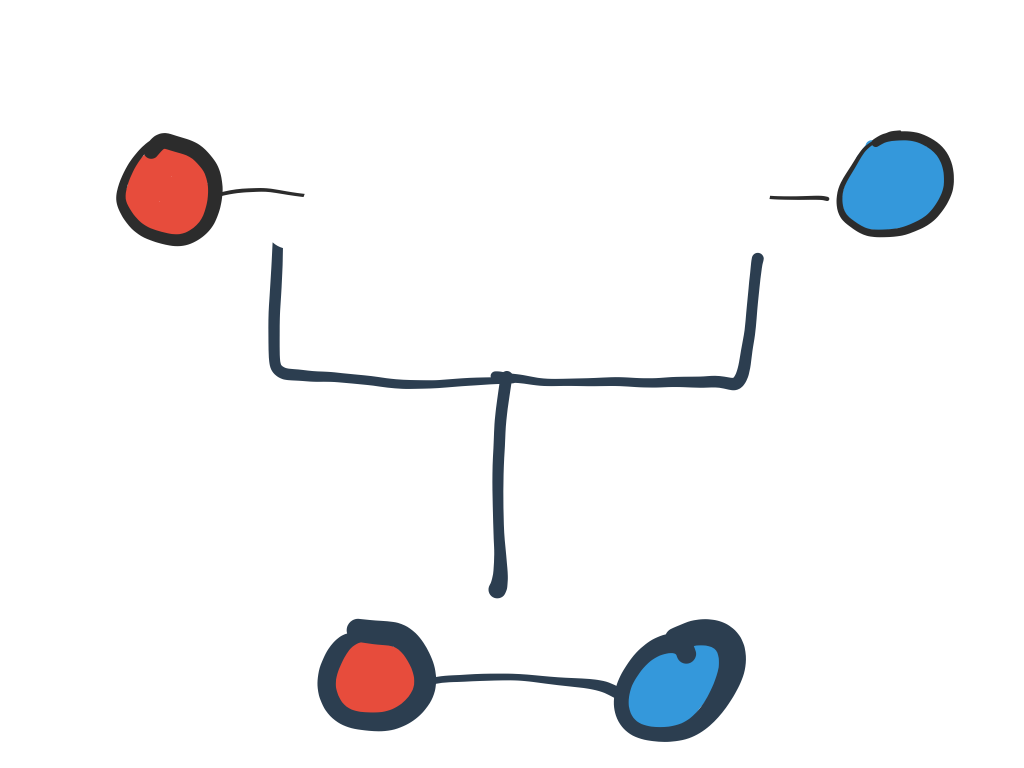

In the first version of the W-F model, we generated a new generation by sampling uniformly at random from the preceding generation. In the new process, we first flip a coin, and with probability $r$, the two genes have two different parents sampled from the preceding generation.

In [11]:
def wf(N, r):
    "Sample parents from the preceding generation under two-locus model."
    parents = []
    for i in range(2 * N):
        if np.random.rand() < r:
            # two parents
            p1, p2 = np.random.choice(2 * N, 2)
            parents.append((p1, p2))
        else:
            p = np.random.choice(2 * N)
            parents.append((p, p))
    return parents


wf(10, 0.01)

[(6, 6),
 (7, 7),
 (18, 18),
 (0, 0),
 (13, 13),
 (7, 7),
 (6, 6),
 (5, 5),
 (10, 10),
 (1, 1),
 (1, 1),
 (7, 7),
 (2, 2),
 (15, 15),
 (5, 5),
 (1, 1),
 (4, 4),
 (17, 17),
 (12, 12),
 (11, 11)]

<IPython.core.display.Javascript object>

If we plot this process, we get a new structure. It is no longer a binary tree, because now nodes can have two parents depending on whether a recombination happened:

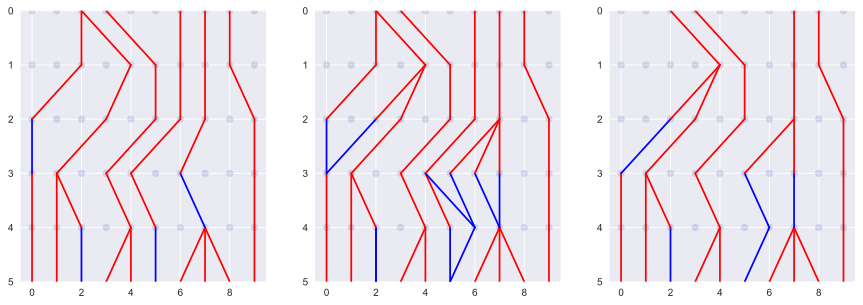

<IPython.core.display.Javascript object>

In [12]:
fig, axs = plt.subplots(figsize=(15, 5), ncols=3)
plot_pop(5, 5, 0.1, follow="both", ax=axs[1])
plot_pop(5, 5, 0.1, follow="left", ax=axs[0])
plot_pop(5, 5, 0.1, follow="right", ax=axs[2])

The plot in the middle shows the genealogy of both chromosomes at once. This structure is known as an "ancestral recombination graph" (ARG). Note that it's no longer a tree! But it contains two embedded subtrees, shown in the plots on the left and right. We recover these trees by following the ARG backwards and either moving left (left plot) or right (right plot) each time we encounter a fork.

## Model of an entire chromosome
Next, we will extend this model to cover an entire chromosome. We will model the chromosome as the unit interval $[0,1)$. Each node in our coalescent "graph" possesses a union of intervals where it carries genetic material that's ancestral to the sample.

Here is an example:

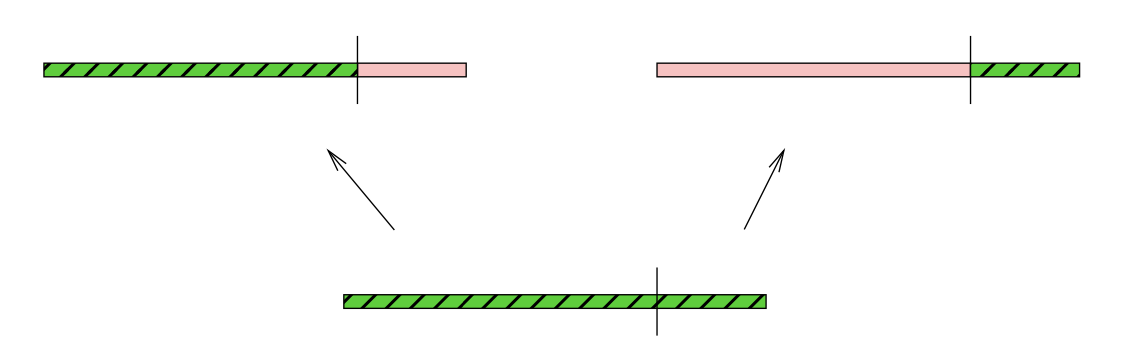

This is a more elaborate example taken from GVE (p. 142):

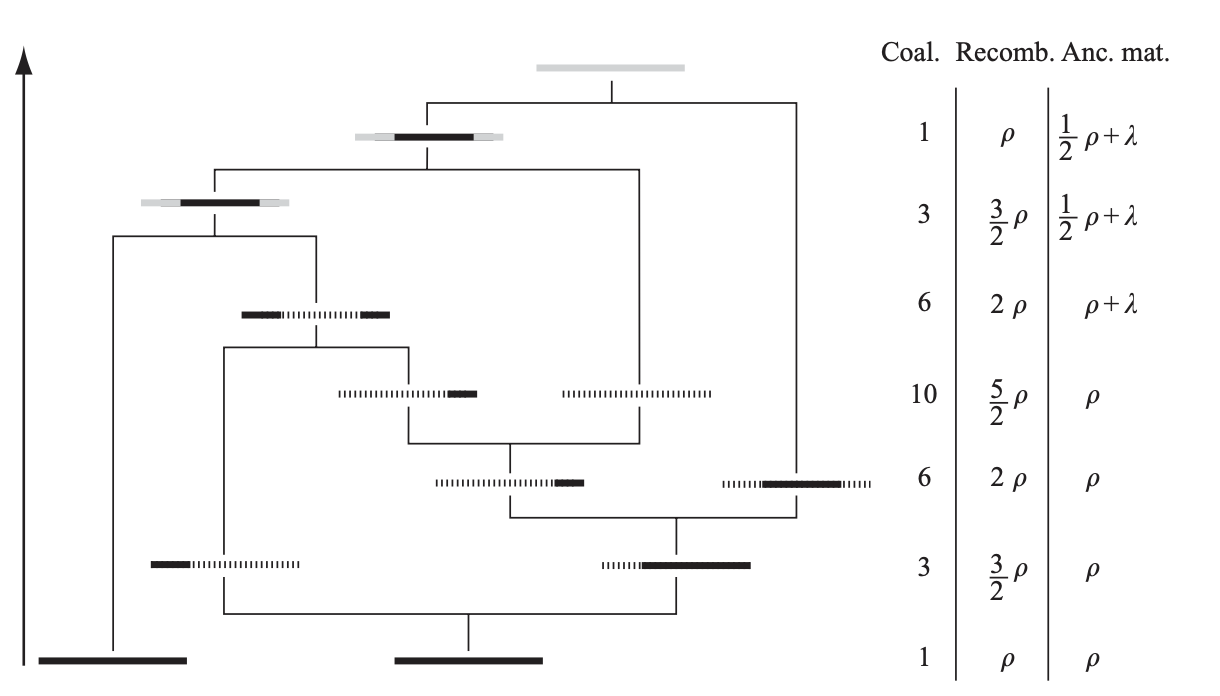

The portions of the chromosome that are solid (black or grey) show up in the present-day sample at the bottom. The portions that are dashed are portions of the chromosome that are not ancestral. Note the existence of a recent relative which is entirely dashed-grey. This person is a genealogical, but not genetic, ancestor.

In [13]:
import portion  # library to simplify all the interval stuff

I = portion.closedopen


def wf_recomb(sample, N, r):
    # run wright-fisher step
    parents = {}
    anc = set()
    for ind in sample:
        if np.random.rand() > r:
            # no recombination
            i = np.random.choice(2 * N)
            parents.setdefault(i, portion.empty())
            parents[i] |= ind
            anc.add(i)
        else:
            # recombination
            # pick a random break point in [0, 1]
            b = np.random.rand()
            i, j = np.random.choice(2 * N, size=2)
            parents.setdefault(i, portion.empty())
            parents.setdefault(j, portion.empty())
            parents[i] |= ind & I(0, b)
            parents[j] |= ind & I(b, 1)
            anc.add(i)
            anc.add(j)
    return [parents[i] for i in anc]

<IPython.core.display.Javascript object>

In [17]:
N = 10
sample = [
    I(0, 1) for _ in range(2)
]  # the interval tracks the "ancestral" material carried by each sample

while len(sample) > 1:
    sample = wf_recomb(sample, N, 0.1)
    print(sample)

[[0,1), [0,1)]
[[0,1), [0,1)]
[[0,1), [0,1)]
[[0,1), [0,1)]
[[0,1), [0,1)]
[[0,1), [0,1)]
[[0,1), [0,1)]
[[0.22759773832225305,1), [0,0.22759773832225305), [0,1)]
[[0,0.22759773832225305), [0,1), [0.22759773832225305,1)]
[[0,1), [0,0.22759773832225305), [0.22759773832225305,1)]
[[0,1), [0.22759773832225305,1), [0,0.22759773832225305)]
[(), [0.22759773832225305,1), [0,1), [0,0.22759773832225305)]
[[0,0.22759773832225305), [0.22759773832225305,1), (), [0,1)]
[[0,1), [0,0.22759773832225305)]
[[0,1), [0,0.22759773832225305)]
[[0,0.22759773832225305), [0,0.4298161592138515), [0.4298161592138515,1)]
[[0,0.22759773832225305), [0,0.4298161592138515), [0.4298161592138515,1)]
[[0.4298161592138515,1), [0,0.4298161592138515), [0,0.22759773832225305)]
[[0,0.22759773832225305), [0,0.4298161592138515), [0.4298161592138515,1)]
[[0,0.22759773832225305), [0,0.4298161592138515), [0.4298161592138515,1)]
[[0.4298161592138515,1), [0,0.4298161592138515), [0,0.22759773832225305)]
[[0.4298161592138515,1), [0,0

<IPython.core.display.Javascript object>

## Genealogical vs. genetic ancestors
An interesting phenomenon occurs when simulating recombination on chromosomal scales. You can have surprisingly recent genealogical ancestors with whom you do not share any genetic material. Let us verify this using the simulator we just wrote:

In [27]:
N = 40_000  # approx human effective population size
r = 1e-9 * 1e8  # probability of recombination in a 100Mb chromosome
sample = [
    I(0, 1) for _ in range(2)
]  # the interval tracks the "ancestral" material carried by each sample
gen = 0
while True:
    gen += 1
    sample = wf_recomb(sample, N, r)
    print("generation:%d ancestors:%d" % (gen, len(sample)))
    if any(ind.empty for ind in sample):
        break
print(gen)

generation:1 ancestors:3
generation:2 ancestors:4
generation:3 ancestors:4
generation:4 ancestors:5
generation:5 ancestors:6
5


<IPython.core.display.Javascript object>

## Hudson's algorithm
Hudson (1983) adapted the coalescent to an algorithm for sampling ARGs under a model with recombination. In the existing coalescent model with recombinations, we essentially replace "mutations" with "recombinations", and add some additional bookkeeping to handle the merging and splitting the intervals.

In [28]:
def hudson(k, rho):
    samples = [[I(0, 1) for _ in range(k)]]
    times = []
    k = len(samples)
    while len(samples) > 1:
        k = len(samples)
        random.shuffle(samples)
        times.append(np.random.exponential(k * (k - 1) / 2 + k * rho / 2))
        if np.random.rand() < (k - 1) / (k - 1 + rho):
            # coalesce two lineages
            samples = [samples[0] | samples[1]] + samples[2:]
        else:
            # recombination
            b = np.random.rand()  # sample recombination breakpoint
            samples = [samples[0] & I(0, b), samples[0] & I(b, 1)] + samples[1:]
    return times

<IPython.core.display.Javascript object>

We won't use Hudson's algorithm too much, because its complexity grows exponentially in $\rho$. We will now show why this is.

## The grand most recent common ancestor (GMRCA)
In Kingman's coalescent, we saw that the expected TMRCA was $$\mathbb{E}T_\text{MRCA}=2\Big(1-\frac{1}{n}\Big).$$
What about for the coalescent with recombination?

### Ancestral process
Define the *ancestral process* $A_n^{(\rho)}(t)$ to be the number of lineages remaining in the coalescent with recombination at time $t$. From Hudson's algorithm, we have that $A_n(t)$ is a CTMC (in fact, a birth/death process) with $A_n(0)=n$ and transition rates
\begin{align}
k &\mapsto k+1\text{ at rate } k\rho/2 \\
k &\mapsto k-1\text{ at rate } \binom{k}{2}.
\end{align}

**Theorem**. Let $W_n^{(\rho)} = \inf \{t: A_n^{(\rho)}(t) = 1\}$ denote the GMRCA in a sample of size $n$. Then $$\mathbb{E}W_n^{(\rho)} = \frac{2}{\rho}\int_0^1 \frac{1-x^{n-1}}{1-x} \big(e^{\rho(1-x)}-1\big)\,dx.$$

**Proof**. The following proof is from Griffiths (1991) and is extremely clever. There is another proof in Durrett (pp. 103-105) using martigale methods which is more laborious, but possibly clearer.

By going backwards one event, we obtain the recursion 
\begin{align}
\mathbb{E}W_n^{(\rho)} &= \frac{1}{\binom{n}{2} + \frac{n\rho}{2}} + \mathbb{E}W_{n-1}^{(\rho)} \frac{n-1}{n-1+\rho} + \mathbb{E}W_{n+1}^{(\rho)} \frac{\rho}{n-1+\rho} \\
 &= \frac{1}{n-1+\rho}\Big(\frac{2}{n} + (n-1)\mathbb{E}W_{n-1}^{(\rho)} + \rho\mathbb{E}W_{n+1}^{(\rho)} \Big)\\
\end{align}
with base case $\mathbb{E}W_{1}^{(\rho)} = 0$.

If we did not have the $\mathbb{E}W_{n+1}^{(\rho)}$ term, this recursion would be easy to solve. To get around this, Griffiths used the trick of introducing a *reflecting boundary* into the recursion. Let $\mathbb{E}W_n^{(\rho,b)}$ be defined by the above recursion for $2\le n \le b - 1$, and for $n=b$ set $\mathbb{E}W_b^{(\rho,b)}=\mathbb{E}W_{b-1}^{(\rho)}$. That is, if the ancestral process hits $b$, it immediately "reflects" back to $b-1$.

Then, for $2\le n\le b-1$,
$$\mathbb{E}W_n^{(\rho,b)} = 2 \sum_{k=2}^n (k-2)! \sum_{j=0}^{b-1-k} \frac{\rho^j}{(j+k)!}.$$ 

Letting $b\to\infty$, we obtain
\begin{align}
\mathbb{E}W_n^{(\rho)} &= 2\sum_{k=2}^n \sum_{j=0}^{\infty} \rho^j \frac{\Gamma(k-1)}{\Gamma(j+k+1)} \\
&= \frac{2}{\rho}\int_0^1 \frac{1-x^{n-1}}{1-x} \big(e^{\rho(1-x)}-1\big)\,dx.
\end{align}

*Exercise*: Prove the preceding three equalities.

### Complexity of Hudson's algorithm
From the preceding result, we can reason that the expected GMRCA in a sample of size $n=2$ is 

$$\mathbb{E}\tau_2 = \frac{2}{\rho}\int_0^1 e^{\rho(1-x)-1}\,dx=\frac{2}{\rho^2}(e^\rho-1-\rho).$$

As $\rho\to0$ we recover the result for Kingman's coalescent, $\mathbb{E}\tau_2 \to 1$. But $\mathbb{E}\tau_2\sim e^\rho$ as $\rho\to\infty$, so we will have to run Hudson's algorithm for an exponential amount of time (in expectation) as $\rho$ grows.